# Random Forest
## Javier Andrés Tiniaco Leyba

A basic implementation of a random forest will be done so that the basic idea and process of the algorithm can be understood. The main idea behind a random forest is the ensemble of many decision trees so that the set of trees is better at it task that the individual tress, so many trees are trained in parallel with different features and data and then, the result of the ensemble for a prediction is the vote of the mayority of the trees.

In [1]:
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
iris = sns.load_dataset('iris')
iris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
52,6.9,3.1,4.9,1.5,versicolor
141,6.9,3.1,5.1,2.3,virginica
36,5.5,3.5,1.3,0.2,setosa
0,5.1,3.5,1.4,0.2,setosa
138,6.0,3.0,4.8,1.8,virginica


Lets build a decision tree. For the classification task, the number of features to use for each tree (f) is calculated as $$f = Floor( Sqrt (F) )$$ being F the number of features in the dataset. So for our case F = 4: $$f = Floor( Sqrt (4) ) = 2$$ 


Ho, Tin Kam (2002). "A Data Complexity Analysis of Comparative
Advantages of Decision Forest Constructors" 

Lets calculate all possible combinations of the two features from the original feature space, which will be used to train the trees.

In [3]:
feat = list(combinations(list(range(4)),2))
feat

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

We can plot the data using the subset of features found.

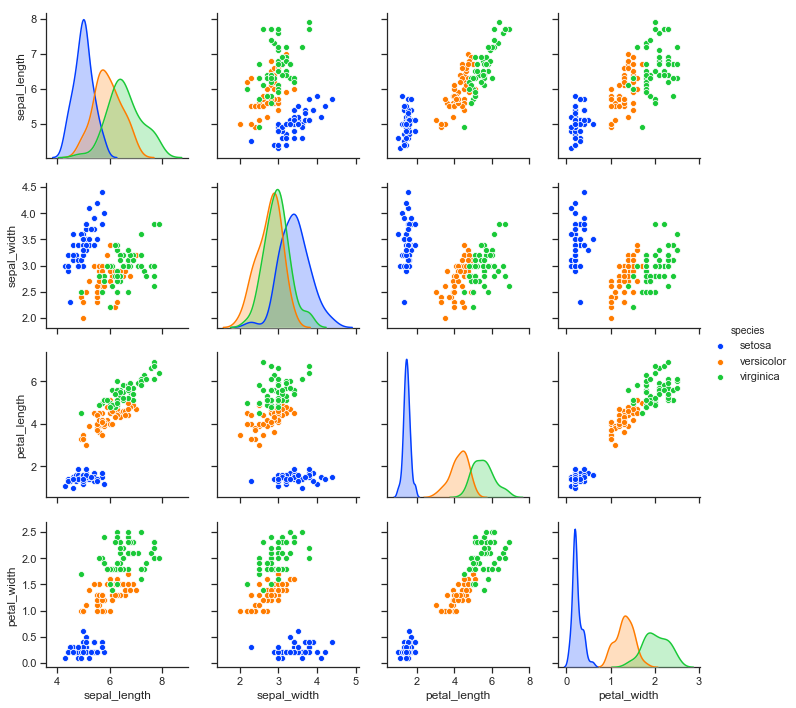

In [4]:
sns.set(style="ticks")
sns.pairplot(iris, hue="species",palette="bright")
plt.show()

In [5]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
# Replace strings by class number
iris['species'] = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica':2})

In [7]:
iris_arr = np.array(iris)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(iris_arr[:,:-1], iris_arr[:,-1], test_size=0.4, random_state=0)

Lets train a decision tree for each feature subset using bootstrapping.

In [9]:
DT = []
for subfeat in feat:
    # Bootstrapping - resampling with replacement
    samples = np.random.randint(len(X_train), size = len(X_train))
    ixgrid = np.ix_(samples, subfeat)
    DT.append(DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=5, min_samples_leaf=10, random_state=42))
    DT[-1].fit(X_train[ixgrid] ,y_train[samples])

Now we make a prediction for the test data with every tree trained and calculate its acuraccy.

In [10]:
acc = []
pred = []
for i in range(len(DT)):
    pred.append(DT[i].predict( X_test[:,feat[i]] ))
    acc.append( accuracy_score(y_test, pred[-1]) )

In [11]:
for i in range(len(DT)):
    print('Accuracy of tree trained with feature subset', feat[i], 'Acc:', np.round(acc[i]*100,2), '%')

Accuracy of tree trained with feature subset (0, 1) Acc: 63.33 %
Accuracy of tree trained with feature subset (0, 2) Acc: 86.67 %
Accuracy of tree trained with feature subset (0, 3) Acc: 93.33 %
Accuracy of tree trained with feature subset (1, 2) Acc: 90.0 %
Accuracy of tree trained with feature subset (1, 3) Acc: 93.33 %
Accuracy of tree trained with feature subset (2, 3) Acc: 93.33 %


The best individual acuraccy is 95%, lets combine the tree predictions vote and check again the accuracy.

In [12]:
RandomForestPred = np.round(sum(pred)/len(DT))

In [13]:
RandomForestPred 

array([2., 1., 0., 2., 0., 2., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 2., 1., 0., 0., 2., 0., 0., 1., 1., 0., 2., 1., 0., 2.,
       2., 1., 0., 1., 1., 1., 2., 0., 2., 0., 0., 1., 2., 2., 1., 2., 1.,
       2., 1., 1., 2., 1., 1., 2., 1., 2.])

In [14]:
acc_random_forest = accuracy_score(RandomForestPred, y_test)

In [15]:
print('Accuracy of random forest using the vote of mayority',np.round(acc_random_forest*100,2), '%')

Accuracy of random forest using the vote of mayority 93.33 %


We can see that this accuracy is slightly lower than the acuraccy of the best individual decision tree. It is important to notice that few trees have been used so, in order to increase the random forest acc, we would need to add many trees, 100 trees are usually taken. Notice also, that the best accuracy of 95% could have been also achieved due to randomness and overfitting, random forest are less prone to overfit than individual trees.

No we use the scikit learn implementation of the random forest and check its accuracy by making use of a 10fold cross validation score, which is more robust than the holdout method used before.

In [16]:
rf = RandomForestClassifier(n_estimators=100)
rf_score = np.mean( cross_val_score(rf, iris_arr[:,:-1], iris_arr[:,-1], cv=5) )

In [17]:
rf_score

0.9666666666666668

As we can see, the RF obtains a better accuracy than any individual model, but for that, we had to use 100 trees.

## Save tree models structure for further analysis

In [18]:
from sklearn.datasets import load_iris
iris_data = load_iris()

In [19]:
feature_names = np.array(iris_data.feature_names)

In [20]:
for i in range(len(feat)):
    dot = export_graphviz(DT[i],
                          out_file=None,
                          feature_names=feature_names[list(feat[i])],
                          class_names=iris_data.target_names,
                          filled=True,
                          impurity=None)

    graph = graphviz.Source(dot)
    name = "iris_decision_tree_acc_" + str(acc[i]) + '_' + str(i)
    graph.render(name)